## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

from models.aef_linear import LinearAEF
from models.autoencoder import ConvolutionalEncoderSmall, IndependentVarianceDecoderSmall
from models.aef_internal import InternalAEF
from bijectors.masked_autoregressive_transform import get_masked_autoregressive_transform
from models.vae import ExtendedVAE

from util import dequantize

from nflows.transforms import InverseTransform, AffineTransform
from bijectors.actnorm import ActNorm
from bijectors.sigmoid import Sigmoid

## Data

In [2]:
transform = transforms.ToTensor()

batch_size = 128

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
p_validation = 0.1
size_validation = round(p_validation * len(train_dataset))
size_train = len(train_dataset) - size_validation
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [size_train, size_validation])
train_dataloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
validation_dataloader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=False)

test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Network
To define our model we require an encoder and decoder, and two normalizing flows. We choose a simple convolutional encoder which outputs a mean and standard deviation, a simple convolutional decoder with a learnable variance, and two masked autoregressive flows.
For AEF-linear we do not require a mask. This results in a likelihood that is defined on an extended ambient space. An importance sampling algorithm to approximate the likelihood restricted to the original variables can be found in the code. For the internal version of AEF, for which we do require a mask, see the end of the notebook.

In [3]:
use_gpu = True
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")

hidden_channels = 64
img_shape = [1, 28, 28]
alpha = 1e-6
latent_dims = 2

encoder = ConvolutionalEncoderSmall(hidden_channels, img_shape, latent_dims)
decoder = IndependentVarianceDecoderSmall(hidden_channels, img_shape, latent_dims)

flow_features = 256
num_layers = 4
core_encoder = get_masked_autoregressive_transform(features=latent_dims, hidden_features=flow_features, num_layers=num_layers,
                                                   num_blocks_per_layer=2, act_norm_between_layers=True)

prior_flow = get_masked_autoregressive_transform(features=latent_dims, hidden_features=flow_features, num_layers=num_layers,
                                                   num_blocks_per_layer=2, act_norm_between_layers=True)

preprocessing_layers = [InverseTransform(AffineTransform(alpha, 1 - 2 * alpha)), Sigmoid(),
                           ActNorm(img_shape[0])] # See paper for details

aef = LinearAEF(encoder, decoder, core_encoder, prior_flow, preprocessing_layers=preprocessing_layers) # AEF linear requires no mask
aef = aef.to(device)

### Training

Training for 5001 iterations...


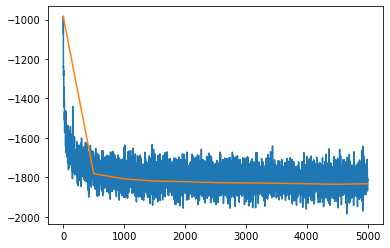

In [4]:
optimizer = torch.optim.Adam(params=aef.parameters(), lr=1e-3)

n_iterations = 5001
stop = False

train_losses = np.zeros((n_iterations, ))
validation_losses = []
validate_every_n_iterations = 500

stop = False
n_iterations_done = 0
print(f'Training for {n_iterations} iterations...')
while not stop:
    for image_batch, _ in train_dataloader:
        image_batch = dequantize(image_batch)
        image_batch = image_batch.to(device)

        loss = torch.mean(aef.loss_function(image_batch))
        train_losses[n_iterations_done] = loss.item()
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()

        if (n_iterations_done % validate_every_n_iterations) == 0:
            aef.eval()

            with torch.no_grad():
                val_batch_losses = np.zeros((len(validation_dataloader), ))

                for val_batch_idx, (validation_batch, _) in enumerate(validation_dataloader):
                        validation_batch = dequantize(validation_batch)
                        validation_batch = validation_batch.to(device)
                        loss = torch.mean(aef.loss_function(validation_batch))
                        val_batch_losses[val_batch_idx] = loss.item()

                validation_losses.append(val_batch_losses.mean())

        aef.train()
        n_iterations_done += 1
        if n_iterations_done >= n_iterations:
            stop = True
            break
plt.plot(range(n_iterations), train_losses)
plt.plot(range(0, n_iterations, validate_every_n_iterations), validation_losses)

In [5]:
aef.eval()
test_losses = np.zeros((len(test_dataloader)))

with torch.no_grad():
    for batch_idx, (test_batch, _) in enumerate(test_dataloader):
        test_batch = dequantize(test_batch)
        test_batch = test_batch.to(device)
        loss = torch.mean(aef.loss_function(test_batch))
        test_losses[batch_idx] = loss.item()

print(f'Test log-likelihood: {test_losses.mean()}')

Test log-likelihood: -1805.13671875


### Comparison with VAE
For comparison, we train a variational autoencoder with the exact same architecture, and compare the samples generated by both models.

In [6]:
encoder = ConvolutionalEncoderSmall(hidden_channels, img_shape, latent_dims)
decoder = IndependentVarianceDecoderSmall(hidden_channels, img_shape, latent_dims)

flow_features = 256
num_layers = 4
core_encoder = get_masked_autoregressive_transform(features=latent_dims, hidden_features=flow_features, num_layers=num_layers,
                                                   num_blocks_per_layer=2, act_norm_between_layers=True, is_inverse=True)

prior_flow = get_masked_autoregressive_transform(features=latent_dims, hidden_features=flow_features, num_layers=num_layers,
                                                   num_blocks_per_layer=2, act_norm_between_layers=True)

preprocessing_layers = [InverseTransform(AffineTransform(alpha, 1 - 2 * alpha)), Sigmoid(),
                           ActNorm(img_shape[0])]
vae = ExtendedVAE(encoder, decoder, core_encoder, prior_flow)
vae = vae.to(device)

Training for 5001 iterations...


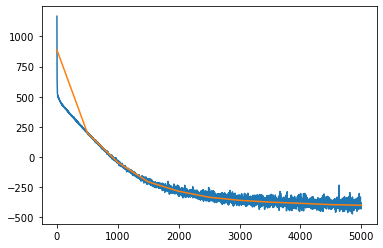

In [7]:
optimizer = torch.optim.Adam(params=vae.parameters(), lr=1e-3)

n_iterations = 5001
stop = False

losses = []
validation_losses = []
validate_every_n_iterations = 500

stop = False
n_iterations_done = 0
print(f'Training for {n_iterations} iterations...')
while not stop:
    for image_batch, _ in train_dataloader:
        image_batch = dequantize(image_batch)
        image_batch = image_batch.to(device)

        loss = torch.mean(vae.loss_function(image_batch))
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        if (n_iterations_done % validate_every_n_iterations) == 0:
            vae.eval()

            with torch.no_grad():
                val_batch_losses = np.zeros((len(validation_dataloader), ))

                for val_batch_idx, (validation_batch, _) in enumerate(validation_dataloader):
                        validation_batch = dequantize(validation_batch)
                        validation_batch = validation_batch.to(device)
                        loss = torch.mean(vae.loss_function(validation_batch))
                        val_batch_losses[val_batch_idx] = loss.item()

                validation_losses.append(val_batch_losses.mean())

        vae.train()
        n_iterations_done += 1
        if n_iterations_done >= n_iterations:
            stop = True
            break
plt.plot(range(n_iterations), losses)
plt.plot(range(0, n_iterations, validate_every_n_iterations), validation_losses)

### Visualizations

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


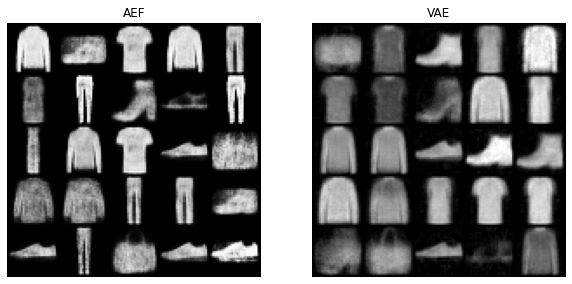

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

aef_samples = aef.sample(25)
vae_samples = vae.sample(25)

grid_aef = torchvision.utils.make_grid(aef_samples, padding=1, pad_value=0., nrow=5)
grid_vae = torchvision.utils.make_grid(vae_samples, padding=1, pad_value=0., nrow=5)

ax1.imshow(grid_aef.permute(1, 2, 0).cpu().numpy())
ax1.axis("off")
ax1.set_title("AEF")

ax2.imshow(grid_vae.permute(1, 2, 0).cpu().numpy())
ax2.axis("off")
ax2.set_title("VAE")

plt.show()

### AEF Internal
We need to create a mask, that will define which pixels are used as 'core' pixels. For simplicity, we choose the first two pixels of the top row of the image. However, there are no restrictions to this mask, as long as the number of masked values is equal to the core size.

In [9]:
mask = torch.zeros(img_shape)
mask[0, 0, :2] = 1

aef_internal = InternalAEF(encoder, decoder, core_encoder, prior_flow, mask, preprocessing_layers)